# Første forsøk på sammenmosing

### Imports

In [1]:
# ToDo: Remove pathlib, only here to find correct paths.
# import pathlib
# print(pathlib.Path().absolute())

# As we are writing in a seperate folder we need to add paths to the other modules not contained in the current system paths.
import sys
sys.path.insert(1,'/home/jetbot')
sys.path.insert(1,'/home/jetbot/monodepth2')

In [2]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

from jetson import utils as utils
import os
import numpy as np
from jetbot import Robot


# Visualizing
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc, animation

# Torch
import torch
import torchvision
from torchvision import transforms


# Monodepth
from monodepth2 import *
import monodepth2.networks as networks
from monodepth2 import utils
from monodepth2.utils import download_model_if_doesnt_exist


# CAMERA
import traitlets
from IPython.display import display, HTML
import ipywidgets.widgets as widgets
from jetbot import Camera, bgr8_to_jpeg, Robot

# Preprocessing
import cv2
import time
import PIL.Image as pil




jetson.utils.__init__.py


In [3]:
# If GPU is available, we will use it for efficiency

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
if __name__ == '__main__':
    print(device)

cuda


## Setting up CA model

In [4]:
model = torchvision.models.alexnet(pretrained=False) # Load Axelnet
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2) #last layer wants 1000 labels, we only need 2, so we swap last layer with a linear binary layer.
model.load_state_dict(torch.load('best_model.pth')) # Load with our best model
model = model.to(device) # Push onto GPU


mean = 255.0 * np.array([0.485, 0.456, 0.406])
stdev = 255.0 * np.array([0.229, 0.224, 0.225])
normalize = torchvision.transforms.Normalize(mean, stdev)

def preprocess(camera_value): # Preprocessing for camera format --> Network input format
    global device, normalize
    x = camera_value
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) #(x, i)
    x = x.transpose((2, 0, 1))
    x = torch.from_numpy(x).float()
    x = normalize(x)
    x = x.to(device)
    x = x[None, ...]
    return x

## Setting up Monodepth model

In [5]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

encoder = networks.ResnetEncoder(18, False).cuda()
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4)).cuda()

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();



## General Setups

In [6]:
camwidth, camheight = 224, 224
cam = Camera.instance(width=camwidth, height=camheight)

robot = Robot()
robot.stop()

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']

print(cam.width, feed_width)
print(cam.height, feed_height)

def geometric_average(l:list):
    return (sum(np.array(l)**2)/len(l))**(1/2)
i = 0
total = []

224 640
224 192


## CA Prep

In [7]:
import torch.nn.functional as Fun

def update(change):
    global robot, prob_blocked
    x = change['new'] 
    x = preprocess(x)
    y = model(x)
    
    # we apply the `softmax` function to normalize the output vector so it sums to 1 (which makes it a probability distribution)
    y = Fun.softmax(y, dim=1)
    
    prob_blocked = float(y.flatten()[0])
    
    if prob_blocked > 0.75:
        if robot.left_motor.value > robot.right_motor.value:
            robot.right(0.4)
        else:
            robot.left(0.4)
        
    time.sleep(0.01)

# update({'new': cam.value})
# cam.observe(update, names='value')

## MD Meat

In [ ]:
inputImage = pil.fromarray(cam.value.astype('uint8'),'RGB')
input_image_resized = inputImage.resize((feed_width, feed_height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0).cuda()

with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)
disp = outputs[("disp", 0)]

disp_resized = torch.nn.functional.interpolate(disp.cpu(), (camheight, camwidth), mode="bilinear", align_corners=False).cuda()
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

# Run

In [8]:
update({'new': cam.value})
cam.observe(update, names='value')
t = time.time()
while True:
    try:
        if prob_blocked < 0.75:
            # preprocessing: 
            inputImage = pil.fromarray(cam.value.astype('uint8'),'RGB') #.rotate(180)
            input_image_resized = inputImage.resize((feed_width, feed_height), pil.LANCZOS)
            input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0).cuda()

            # MD net
            with torch.no_grad():
                features = encoder(input_image_pytorch)
                outputs = depth_decoder(features)
            disp = outputs[("disp", 0)]
            
            disp_resized = torch.nn.functional.interpolate(disp.cpu(), (camheight, camwidth), mode="bilinear", align_corners=False).cuda()
            disp_resized_np = disp_resized.squeeze().cpu().numpy()
            vmax = np.percentile(disp_resized_np, 95)


            # MD Motot Calc and Func
            A = []
            B = []
            C = []
            edge1 = round(camwidth/3)
            edge2 = round(2*camwidth/3)
            for w in range(camheight):
                for j in range(edge1):
                    A.append(disp_resized_np[w][j])
                for j in range(edge1, edge2):
                    B.append(disp_resized_np[w][j])
                for j in range(edge2, camwidth):
                    C.append(disp_resized_np[w][j])

            B_scale = 1 - geometric_average(B)/np.max(disp_resized_np)
            right_motor = 2*(0.5 - geometric_average(A)*B_scale)
            left_motor = 2*(0.5 - geometric_average(C)*B_scale)

            robot.set_motors(left_motor, right_motor)
            print("Turnaround time: ", round(time.time() - t, 2), "L,R = ", left_motor, right_motor)
            t = time.time()
            
    except KeyboardInterrupt:
        cam.unobserve(update, names='value')
        robot.stop()
        break

Turnaround time:  2.44 L,R =  0.18421762445475387 0.53449904614703
Turnaround time:  0.68 L,R =  0.17553049028006928 0.5291427834407103
Turnaround time:  0.63 L,R =  0.20436316045196856 0.49531967959567536
Turnaround time:  0.61 L,R =  0.5273608523898221 0.5803868148996751
Turnaround time:  0.74 L,R =  0.7021446076705249 0.6776393637077738
Turnaround time:  1.03 L,R =  0.6303161371161858 0.375342033735215
Turnaround time:  0.63 L,R =  0.7058727525365324 0.7015449704131226
Turnaround time:  0.62 L,R =  0.5182806068357146 0.6597457980502944
Turnaround time:  0.6 L,R =  0.6440333735142882 0.5202984416927856
Turnaround time:  0.64 L,R =  0.22946753359656247 0.5499215818694119
Turnaround time:  0.63 L,R =  0.7281885439663058 0.6857545730054
Turnaround time:  0.63 L,R =  0.6352319773008452 0.6428441745732327
Turnaround time:  0.63 L,R =  0.725309257405682 0.6843533812847125
Turnaround time:  0.63 L,R =  0.6980405254414979 0.7047497949261144
Turnaround time:  0.61 L,R =  0.6627113695259932 0.

# Teardown

In [ ]:
cam.unobserve(update, names='value')
robot.stop()

In [ ]:
robot.stop

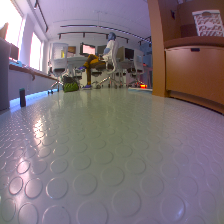

In [10]:
pil.fromarray(cam.value.astype('uint8'),'RGB')

In [ ]:
pil.fromarray(cam.value.astype('uint8'),'RGB')